In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reset -f

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

import caffe
caffe.set_mode_gpu()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/mukul/development/deepLearning/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/mukul/development/deepLearning/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/mukul/development/deepLearning/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion meth

In [134]:
import python.helpers as helpers
import matplotlib
import lmdb
import cv2

In [13]:
solverPrototxt = "models/Sunset_solver.prototxt"
testingPrototxt = "models/Sunset_deploy.prototxt"

trainingLogFile = "logs/train_Sunset.log"
testingData ="bin/Sunset_test_lmdb"

trainedModel = "snapshots/Sunset_iter_5000.caffemodel"

In [8]:
#Do the magic
os.system("bash run_training_pipeline.sh Sunset --arch0 --finetune --resize_height=256 --resize_width=256")

0

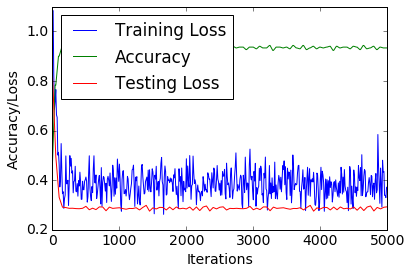

Baseline training loss 0.82935
Baseline test accuracy 0.466667
Final training loss 0.292699
Final test accuracy 0.933333


In [130]:
#Show training graph
matplotlib.rcParams.update({'font.size': 14})
iterations, losses = helpers.getTrainingLossFromTrainingFile(trainingLogFile)
plt.plot(iterations, losses, label="Training Loss")

iterations, accuracy = helpers.getAccuracyFromTrainingFile(trainingLogFile)
plt.plot(iterations, accuracy, label="Accuracy")

iterations, losses = helpers.getTestingLossFromTrainingFile(trainingLogFile)
plt.plot(iterations, losses, label="Testing Loss")

plt.xlabel("Iterations")
plt.ylabel("Accuracy/Loss")

plt.legend(loc='upper left')

plt.show()

print "Baseline training loss " + losses[0]
print "Baseline test accuracy " + accuracy[0]

print "Final training loss " + losses[-1]
print "Final test accuracy " + accuracy[-1]

In [131]:
net = caffe.Net(testingPrototxt, trainedModel, caffe.TEST)

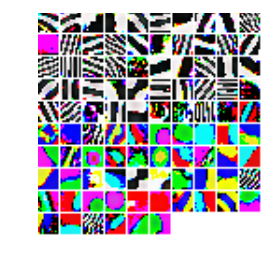

[[ 0.17959082  0.82040912]]


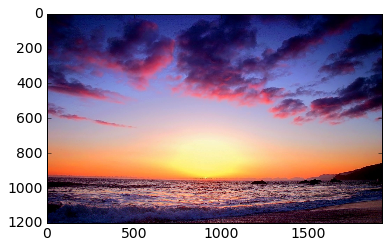

In [132]:
#Visualize learned filters from first layer
filters = net.params["conv1"][0].data
helpers.showFilterGrid(filters.transpose(0, 2, 3, 1), False)
plt.show()

#Play-around with initial network
net.blobs['data'].reshape(1,3,227,227)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)
transformer.set_mean('data', np.array([104,117,123]))
transformer.set_channel_swap('data', (2,1,0))

im = caffe.io.load_image('wild/Sunset/7041778-twilight-sunset.jpg')
plt.imshow(im)
im = transformer.preprocess('data', im)
net.blobs['data'].data[...] = im

net.forward()
probabilities = net.blobs['prob'].data
print probabilities

In [38]:
del net

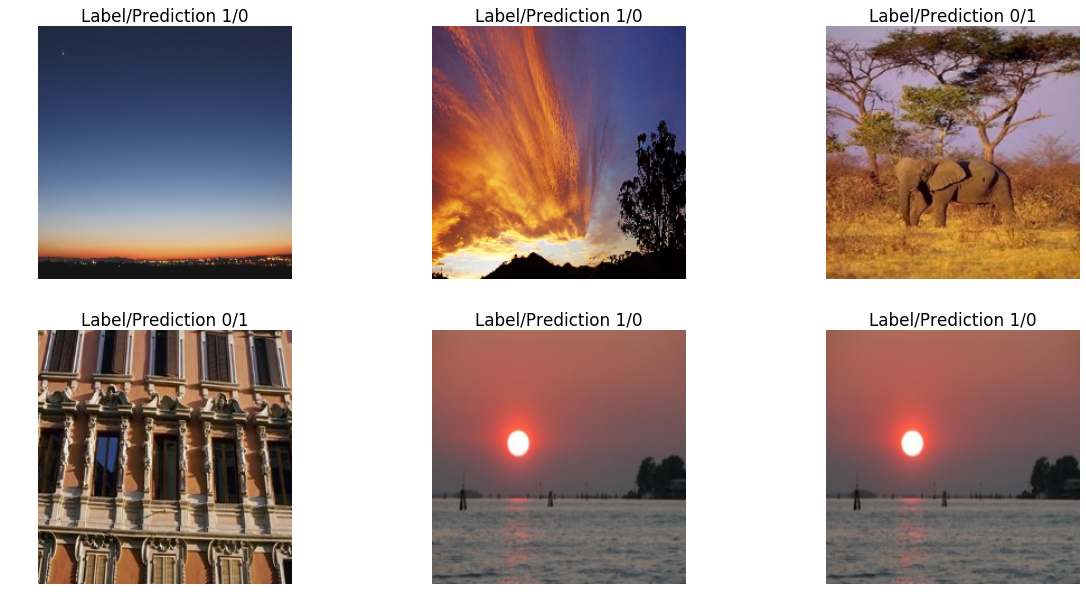

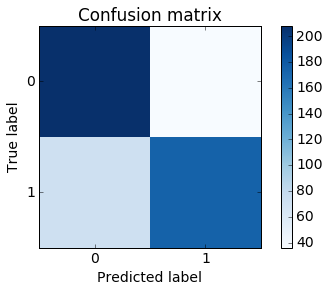

In [139]:
#Confusion matrix and eyeballing incorrect thru python using deploy model
net = caffe.Net(testingPrototxt, trainedModel, caffe.TEST)

caffe.set_mode_cpu()

lmbd_env = lmdb.open(testingData)
reader = helpers.lmdb_reader(lmbd_env)

net.blobs['data'].reshape(1,3,227,227)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)
transformer.set_mean('data', np.array([104,117,123]))

numToEyeball = 6
numIncorrect = 0
shapeSubplot = (numToEyeball/3, 3)
groundTruths = np.empty((0), dtype=int)
predictions = np.empty((0), dtype=int)

plt.figure(figsize=(20,10))
for i, image, label in reader:
    image = helpers.crop(image, net.blobs['data'].data.shape).transpose(1,2,0)
    im = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = im
    out = net.forward()
    
    prediction = int(out['prob'][0].argmax(axis=0))
    iscorrect = label == prediction
    groundTruths = np.append(groundTruths, label)
    predictions = np.append(predictions, prediction)

    if not iscorrect and numIncorrect < numToEyeball:
        index = np.unravel_index(numIncorrect, shapeSubplot)
        plt.subplot(shapeSubplot[0], shapeSubplot[1], numIncorrect + 1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Label/Prediction " + str(label) + "/" + str(prediction))
        numIncorrect += 1

lmbd_env.close()      
plt.show()

helpers.showConfusionMatrix(helpers.getConfusionMatrix(groundTruths, predictions), np.arange(2))
plt.show()

del net